# Project 2: inverse kinematics and resolved rate control

In this project, we will implement an inverse kinematics algorithm and controllers for the Kuka iiwa 14 robot using the results from Project 1.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.

As a reminder, the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa) has 7 revolute joints and its kinematics is described in the picture below:

![](./kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [410]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [411]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project2'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project2/')
    os.chdir('/content/ROB6003/Project2/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [412]:
import numpy as np
import robot_visualizer
import time

import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


D:\User\anaconda\lib\site-packages\pinocchio\shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7002/static/


# Displaying an arbitrary configuration

As in the previous project, you can use the following function to display arbitrary configurations of the robot

In [413]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [0.12836667 0.19579704 0.95917033 0.56037159 0.77821555 0.39731994
 0.85164281]


In [426]:
# Basic data for the question
# import functions we defined before
import calcurobots as cr
from scipy.linalg import expm
from scipy.linalg import logm

# Not output in scientific notation
np.set_printoptions(suppress=True)

gap = [0.1575, 0.2025, 0.2045, 0.2155, 0.1845, 0.2155, 0.0810]
h = [0.1575]
for i in range(1,len(gap)):
    h.append(gap[i]+h[i-1])

# Write down p in 3 × 7 form.
# if you wanna get p1 = [ [0], [0], [ h[0] ] ], use p[:,0].reshape(-1,1)
p = np.array([
    [0,       0,       0,       0,       0,          0,      0],
    [0,       0,       0,       0,       0,    -0.0607,      0],
    [h[0],    h[1],    h[2],    h[3],    h[4],       h[5],   h[6]]
])

# Write down w in 3 × 7 form.
# if you wanna get w1 = [ [0], [0], [1] ], use w[:,0].reshape(-1,1)
w = np.array([
    [0,    0,    0,    0,    0,    0,   0],
    [0,    1,    0,   -1,    0,    1,   0],
    [1,    0,    1,   -0,    1,    0,   1]
])

# Value for testing
w1 = np.array([ [0], [0], [1] ])
p1 = np.array([ [0], [0], [ h[0] ] ])
theta2 = [0.2, -0.2, 0.5, -0.4, 1.2, -0.8, 0.4]

# Get all Twists from w and p
S = np.array([ [], [], [], [], [], [] ])

for i in range(7):
    S = np.hstack( ( S, cr.getTwistfromwp( w[:,i].reshape(-1,1), p[:,i].reshape(-1,1) ) ) )

# some irrelevent data, not related with current function
p = np.array([ [0], [0], [0] ])

R = np.array([
    [1,          0,          0], 
    [0,          1,          0],
    [0,          0,          1]  
])

# -------------------------------------------------------------------------------------------------------------

# FK(0,0,0,0,0,0,0)
M = np.array([
    [1,     0,      0,      0],
    [0,     1,      0,      0],
    [0,     0,      1,      1.301],
    [0,     0,      0,      1]
])

# Forward_kinematics
def forward_kinematics(theta):

    FK = np.identity(4)

    for i in range(7):
        exp_MS = expm(cr.getMatrixTwist(S[:,i].reshape(-1,1)) * theta[i])
        FK = FK @ exp_MS

    return FK @ M

#check if the result is correct
print( np.around( forward_kinematics(theta2), 3) )

def get_space_jacobian(theta):

    #set initial value
    Spatial_Jacobian = S[:,0].reshape(-1,1)
    exp_MS = expm( cr.twist_to_skew(S[:,0].reshape(-1,1) * theta[0])   )

    for i in range(1,7):

        exp_MS = exp_MS @ expm(cr.twist_to_skew(S[:,i].reshape(-1,1)) * theta[i] )

        Ad_M = cr.getAdjoint(exp_MS)

        Jspace = Ad_M @ S[:,i].reshape(-1,1)

        Spatial_Jacobian = np.hstack( (Spatial_Jacobian, Jspace) )

    return Spatial_Jacobian 
    
# From Jspace to Jbody
def getJbody(Jspace, M):

    Mt = cr.getInversedT(M)
    Body_Jacobian = cr.getAdT(Mt)@ Jspace

    return Body_Jacobian
#check if the result is correct
print( np.around ( get_space_jacobian(theta2), 3 ) )

saved_theta = np.array([
    [-13.7      ,    1.22537113 , -3.34843113 ,-12.1    ,     -1.28072149 ,30.3     ,    12.1       ,  -2.36527832 , -0.28781834, -3.41185656],
    [ 13.6       ,  -5.89995099 , -6.16534837 , 12.6     ,    -6.14738237 ,75.2   ,      30.7      ,   -5.46155611  , 6.15009695 , -0.61329978],
    [-10.6      ,   -3.43543765 , -0.48659147 , 13.6   ,       0.57979485 ,10.1      ,  -23.8         , 3.79044346  , 3.3462569  , -0.05530988],
    [ 12.6      ,   -5.28165779 ,  4.81259415, -12.      ,    -1.32943846  ,-88.1   ,     -18.7        ,  0.50115586  , 1.39618731 , -5.47276698],
    [-12.9    ,     -2.72716978  , 5.84854233 ,-42.2    ,     -0.7663601  ,42.7   ,      43.1     ,    -0.20477105,  2.52652381  ,-2.79808514],
    [ 31.4     ,    -5.61709744 ,  1.61941705  , 7.9       ,  -4.82800276  ,-24.9       , 150.7   ,     -0.68205762 , 15.4450743   ,-5.42197938],
    [ 24.1  ,        3.25989027 ,  7.22381602 ,-18.4  ,       2.51077233 ,51.8      ,    10.         ,  2.8756151   ,-3.94374454 , -0.03212578]
])

saved_theta_nullspace = np.array([
 [  1.000,     1.000,     1.000,    1.000,      1.000,     1.000,     1.000,    1.000,      1.000,      1.000  ],
 [  5.51 ,  0.37  , 0.15  , 6.36  , 6.14 ,-18.68 , -0.74  , 5.56  , 0.18  , 0.56],
 [  1.48  , 0.03 ,  1.12 , -1.69 , -1.43 , -3.95 , -5.15 , -0.08 , -1.7  , -1.66],
 [  1.24  ,-1.01 , -1.77  ,-5.33 , -1.51 ,-12.89 ,-13.45 , -5.64  ,-1.55 , -1.63],
 [ 13.68 ,  3.53 ,  1.42 , 23.89  , 2.05 ,-17.92 ,-15.6   , 0.52 , -5.76 , -4.69],
 [  6.2  ,  5.64  , 1.59  ,14.76 , -8.16 ,  4.93 , -7.01 ,  5.87 , -9.26 ,  0.34],
 [ 12.6  , -2.74 ,  2.57 ,  7.04  , 2.47 ,25.08 ,-13.9   , 3.08 ,  7.15 , -3.92]
 ])

initial_theta_nullspace = np.array([
    [1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001],
    [1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001],
    [-1.001, -1.001 , -1.001, -1.001  ,-1.001 , -1.001, -1.001 , -1.001 ,-1.001 , -1.0588],
    [-1.001, -1.001 , -1.001, -1.001  ,-1.001 , -1.001, -1.001 , -1.001 ,-1.001 , -1.0588],
    [1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001],
    [1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001],
    [1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001,  1.001]
 ])

save_solution = np.array([
 [3.47929649,-4.85905387],
 [-0.6415276,0.37347647],
 [3.19288371,-0.4585807],
 [5.5332155,5.5372262],
 [2.47376351,-3.80869246],
 [5.29469703,-7.35879002],
 [3.30724482,-2.9276608],
])

#print(saved_theta_nullspace)

[[-0.495 -0.814  0.304 -0.   ]
 [ 0.629 -0.577 -0.522  0.006]
 [ 0.6   -0.067  0.797  1.256]
 [ 0.     0.     0.     1.   ]]
[[ 0.    -0.199 -0.195  0.635  0.112 -0.943  0.304]
 [ 0.     0.98  -0.039 -0.767  0.213 -0.287 -0.522]
 [ 1.     0.     0.98   0.095  0.971  0.172  0.797]
 [ 0.    -0.353  0.014  0.59  -0.181  0.344  0.66 ]
 [ 0.    -0.072 -0.07   0.498  0.166 -1.087  0.382]
 [ 0.     0.    -0.     0.073 -0.016  0.075 -0.002]]


## Question 1: inverse kinematics
* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1,1,-1,-1,1,1,1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?

In [415]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)

print(desired_endeff)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    time.sleep(1.)

[[ 0.38339707  0.31544311 -0.31553973 -0.11821891  0.2850429  -0.15173455
  -0.79793568 -0.48681569  0.04619614  0.70473966]
 [-0.95646426  0.57340228  0.30478196 -0.19842012 -0.3891786   0.26826613
   0.42569676 -0.75169487 -0.01482287 -0.18653133]
 [ 1.01716708  0.77787234  0.66883442  1.10724207  0.73680682  1.31846463
   1.29349058  0.7639032   0.88767443  0.6875047 ]]


In [416]:
import random
def compute_IK_position(x,save):
    computed_position = np.array([ [], [], [] ])
    computed_theta = np.array([ [],[],[],[],[],[],[] ])
    count = 0
    #print("Minimum Error:")
    for i in range(x.shape[1]):
    #for i in range(1):
            print("Position No.", i+1)
            # get desired postions and divide them into way points
            wp = list(map(lambda x: x * 0.1,list(range(1,11))))
            p_des = x[:,i].reshape(-1,1)
            p_des_wp_matrix = p_des @ np.array([ wp ])
            
            # set proper initial value
            theta_precies = np.random.uniform(low = -5, high = 5, size=7).tolist()
            #theta_precies = saved_theta[:,i]
            epsilon = random.uniform(0.2, 0.6)
            # set way points as a p_des, prepare for iteration
            print("theta0:", np.around(theta_precies,3),"epsilon = ", epsilon)
            for j in range(10):
                theta = theta_precies
                p_des_wp = p_des_wp_matrix[:,j].reshape(-1,1)
                p_fk = forward_kinematics(theta)[0:3,3].reshape(-1,1)
                epsilon = epsilon * 0.95
                # compute error, create vector to save precies value
                error = p_des_wp - p_fk
                abs_error = np.linalg.norm(error, ord = 2)
                error_precies = abs_error

                # iterating
                for h in range(500):
                    p_fk = forward_kinematics(theta)[0:3,3].reshape(-1,1)
                    error = p_des_wp - p_fk
                    abs_error = np.linalg.norm(p_des_wp - p_fk, ord = 2)

                    # Try to find precies value, if there is, save it
                    if abs_error - error_precies <= 0.0000001:
                        theta_precies = theta
                        error_precies = abs_error

                    # compute pesudo-jacobian
                    pesudo_jacobian = np.linalg.pinv(get_space_jacobian(theta)[3:,:])
                    
                    # set theta 1
                    theta = theta + epsilon * (pesudo_jacobian @ error)[:,0]
                #print("No.", j+1 ,"iteration, the theta, position, error are:","\n", np.around(theta_precies,3),"\n", forward_kinematics(theta_precies)[0:3,3],"\n", p_des_wp[:,0] ,error_precies,"\n")
            accurate_position = forward_kinematics(theta_precies)[0:3,3].reshape(-1,1)
            print("Final distance = ",error_precies)
        
            computed_position = np.hstack( (computed_position,accurate_position) )
            computed_theta = np.hstack(  ( computed_theta, np.array(theta_precies).reshape(-1,1) )  )
            # precies solution, saved
            if error_precies <= 0.000001:
                count = count + 1
                save[:,i] = theta_precies
            # better solution, saved
            if error_precies - np.linalg.norm(x[:,i].reshape(-1,1)-forward_kinematics(save[:,i])[0:3,3].reshape(-1,1), ord = 2) <= 0.000001:
                save[:,i] = theta_precies
    print("Accurate Value Num:",count)
    return computed_theta,computed_position
    
def compute_IK_position_nullspace(x):
    computed_position = np.array([ [], [], [] ])
    computed_theta = np.array([ [],[],[],[],[],[],[] ])
    count = 0
    #print("Minimum Error:")
    for i in range(x.shape[1]):
    #for i in range(1):
            print("Position No.", i+1)
            # get desired postions and divide them into way points
            wp = list(map(lambda x: x * 0.1 ,list(range(1,11))))
            p_des = x[:,i].reshape(-1,1)
            p_des_wp_matrix = p_des @ np.array([ wp ])
            
            # set proper initial value
            #theta_precies = np.random.uniform(low = -5, high = 5, size=7).tolist()
            theta_precies = initial_theta_nullspace[:,i]
            #theta_precies = saved_theta_nullspace[:,i]
            epsilon = random.uniform(0.2, 0.6)
            # set way points as a p_des, prepare for iteration
            print("theta0:", np.around(theta_precies,3),"epsilon = ", epsilon)
            for j in range(10):
                theta = theta_precies
                p_des_wp = p_des_wp_matrix[:,j].reshape(-1,1)
                p_fk = forward_kinematics(theta)[0:3,3].reshape(-1,1)
                epsilon = epsilon * 0.95
                # compute error, create vector to save precies value
                error = p_des_wp - p_fk
                abs_error = np.linalg.norm(error, ord = 2)
                error_precies = abs_error

                # iterating
                for h in range(200):
                    p_fk = forward_kinematics(theta)[0:3,3].reshape(-1,1)
                    error = p_des_wp - p_fk
                    abs_error = np.linalg.norm(p_des_wp - p_fk, ord = 2)

                    # Try to find precies value, if there is, save it
                    if abs_error - error_precies <= 0.0000001:
                        theta_precies = theta
                        error_precies = abs_error

                    # compute pesudo-jacobian
                    pesudo_jacobian = np.linalg.pinv(get_space_jacobian(theta)[3:,:])
                    
                    # set theta 1
                    theta = theta + epsilon * (pesudo_jacobian @ error)[:,0]
                #print("No.", j+1 ,"iteration, the theta, position, error are:","\n", np.around(theta_precies,3),"\n", forward_kinematics(theta_precies)[0:3,3],"\n", p_des_wp[:,0] ,error_precies,"\n")
            accurate_position = forward_kinematics(theta_precies)[0:3,3].reshape(-1,1)
            print("Final distance = ",error_precies)
        
            computed_position = np.hstack( (computed_position,accurate_position) )
            computed_theta = np.hstack(  ( computed_theta, np.array(theta_precies).reshape(-1,1) )  )
            # precies solution, saved
            if error_precies <= 0.000001:
                count = count + 1
                saved_theta_nullspace[:,i] = theta_precies
            # better solution, saved
            if error_precies - np.linalg.norm(x[:,i].reshape(-1,1)-forward_kinematics(saved_theta_nullspace[:,i])[0:3,3].reshape(-1,1), ord = 2) <= 0.000001:
                saved_theta_nullspace[:,i] = theta_precies
    print("Accurate Value Num:",count)
    return computed_theta,computed_position

                    #theta_nullspace = theta_nullspace + epsilon * (pesudo_jacobian @ error + (np.identity(7) - pesudo_jacobian @ jacobian) @ theta_bar )[:,0]

In [417]:
# Run more and save best solution. Here with 10 way points, 200 times iteration,, 10 positions, 1 circle time ≈ 1 min
for h in range(1): 
    x,computed_position = compute_IK_position(desired_endeff,saved_theta)
    print("history good answer:\n", np.around(saved_theta,1))
    history_position = np.array([ [], [], [] ])
    for i in range(x.shape[1]):
        position = forward_kinematics(saved_theta[:,i])[0:3,3].reshape(-1,1)
        history_position = np.hstack( (history_position,position) )
        save_error = np.linalg.norm(desired_endeff[:,i].reshape(-1,1)-position, ord = 2)
        print("best endoff:",save_error)

# save converged answer
print("The result of IK:\n")
#print("history good answer:\n", saved_theta)
print("history good answer:(Keep two decimal places)\n", np.around(saved_theta,2))
print("history best position\n",np.around(history_position,3))
print("Desired_endoff:\n",np.around(desired_endeff,3))
#print("\nLast_Compute_endoff:\n",np.around(computed_position,3))
#print("Last_Precise Theta:\n",np.around(x,1))
#print(np.around( np.linalg.norm(desired_endeff[:,0].reshape(-1,1)-computed_position[:,0].reshape(-1,1), ord = 2),3) )


Position No. 1
theta0: [ 0.399 -2.644 -4.563 -2.295  3.547 -3.386 -2.361] epsilon =  0.5211627679177581
Final distance =  0.7211425811923873
Position No. 2
theta0: [-4.199  4.171 -4.59   4.182  0.511 -2.274  0.444] epsilon =  0.29452001458998883
Final distance =  0.07252882608712964
Position No. 3
theta0: [-1.2    2.304  2.887 -4.273  3.819 -4.686 -2.747] epsilon =  0.43874592781055166
Final distance =  0.03173997113238486
Position No. 4
theta0: [-3.45  -1.477  3.911 -4.35   1.795  1.521  3.301] epsilon =  0.24410815992516946
Final distance =  0.1988601912920357
Position No. 5
theta0: [-4.994  1.128 -4.675 -1.355 -0.612 -3.301  1.664] epsilon =  0.29508619590401053
Final distance =  0.08374752145463579
Position No. 6
theta0: [-4.223 -1.632 -3.211 -4.79  -0.281 -1.209  0.456] epsilon =  0.5555803104716941
Final distance =  0.16394273225784514
Position No. 7
theta0: [-1.896 -2.821 -3.57   1.451 -4.942  3.844 -4.974] epsilon =  0.4880764058093182
Final distance =  0.6897661154598747
Posit

In [418]:
# Run more and save best solution. Here with 10 way points, 200 times iteration,, 10 positions, 1 circle time ≈ 1 min
for h in range(1): 
    x_nullspace,computed_position_nullspace = compute_IK_position_nullspace(desired_endeff)
    print("history good answer:\n", np.around(saved_theta_nullspace,1))
    history_position_nullspace = np.array([ [], [], [] ])
    for i in range(x_nullspace.shape[1]):
        position = forward_kinematics(saved_theta_nullspace[:,i])[0:3,3].reshape(-1,1)
        save_error_nullspace = np.linalg.norm(desired_endeff[:,i].reshape(-1,1)-position, ord = 2)
        history_position_nullspace  = np.hstack( (history_position_nullspace ,position) )
        print("best endoff nullspace:",save_error_nullspace)

# save converged answer
print("The result of IK_nullspace:")
#print("history best answer:\n", saved_theta_nullspace,)
print("history good answer:(Keep two decimal places)\n", np.around(saved_theta_nullspace,2))
print("history best position\n",np.around(history_position_nullspace ,3))
print("Desired_endoff:\n",np.around(desired_endeff,3))
#print("\nLast_Compute_endoff:\n",np.around(computed_position_nullspace ,3))
#print("\nLast_Precise Theta:\n",np.around(x_nullspace,2))
#print(np.around( np.linalg.norm(desired_endeff[:,0].reshape(-1,1)-computed_position[:,0].reshape(-1,1), ord = 2),3) )

Position No. 1
theta0: [ 1.001  1.001 -1.001 -1.001  1.001  1.001  1.001] epsilon =  0.4813345772699724
Final distance =  0.46597061821657654
Position No. 2
theta0: [ 1.001  1.001 -1.001 -1.001  1.001  1.001  1.001] epsilon =  0.4635381092562298
Final distance =  0.0004411013935238358
Position No. 3
theta0: [ 1.001  1.001 -1.001 -1.001  1.001  1.001  1.001] epsilon =  0.5395309396743504
Final distance =  0.03749944050668001
Position No. 4
theta0: [ 1.001  1.001 -1.001 -1.001  1.001  1.001  1.001] epsilon =  0.31109613476162173
Final distance =  0.361338665597439
Position No. 5
theta0: [ 1.001  1.001 -1.001 -1.001  1.001  1.001  1.001] epsilon =  0.2113252511469082
Final distance =  0.10031185929102561
Position No. 6
theta0: [ 1.001  1.001 -1.001 -1.001  1.001  1.001  1.001] epsilon =  0.3404829906043094
Final distance =  0.20400890095763527
Position No. 7
theta0: [ 1.001  1.001 -1.001 -1.001  1.001  1.001  1.001] epsilon =  0.5668014267269932
Final distance =  0.6492957906765712
Positi

## Question 2: Joint control and joint trajectories generation
We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities

In [419]:
# Compute inverse kinematics solutions
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])
end_effector_goal = np.hstack((end_effector_goal1,end_effector_goal2))

for h in range(1): 
    solution, solution_position= compute_IK_position(end_effector_goal,save_solution)
    #print("history good answer:\n", np.around(save_solution,1))
    history_position = np.array([ [], [], [] ])
    for i in range(end_effector_goal.shape[1]):
        position = forward_kinematics(save_solution[:,i])[0:3,3].reshape(-1,1)
        history_position = np.hstack( (history_position, position) )
        save_error = np.linalg.norm(end_effector_goal[:,i].reshape(-1,1)-position, ord = 2)
        print("best endoff:",save_error)

print("The result of IK:")
print("history best answer:\n theta_position1:\n", save_solution[:,0],"\ntheta_position2:\n",save_solution[:,1])
#print("history good answer:(Keep two decimal places)\n", np.around(save_solution,2))
print("history best position\n",np.around(history_position,3))
print("Desired_endoff:\n",np.around(end_effector_goal,3))

"""
Solution:
[[ 3.47929649 -4.85905387]
[-0.6415276   0.37347647]
[ 3.19288371 -0.4585807 ]
[ 5.5332155   5.5372262 ]
[ 2.47376351 -3.80869246]
[ 5.29469703 -7.35879002]
[ 3.30724482 -2.9276608 ]]
"""

Position No. 1
theta0: [-0.762 -0.48   1.933 -1.629  1.963 -1.256 -0.318] epsilon =  0.22375910259848217
Final distance =  0.14838034840514944
Position No. 2
theta0: [-3.255  3.298 -3.864  1.665 -3.805  0.764  4.005] epsilon =  0.3370597144274431
Final distance =  0.2167680832103208
Accurate Value Num: 0
best endoff: 1.3715902973574284e-07
best endoff: 5.247264471659592e-06
The result of IK:
history best answer:
 theta_position1:
 [ 3.47929649 -0.6415276   3.19288371  5.5332155   2.47376351  5.29469703
  3.30724482] 
theta_position2:
 [-4.85905387  0.37347647 -0.4585807   5.5372262  -3.80869246 -7.35879002
 -2.9276608 ]
history best position
 [[0.7 0.3]
 [0.2 0.5]
 [0.7 0.9]]
Desired_endoff:
 [[0.7 0.3]
 [0.2 0.5]
 [0.7 0.9]]


In [476]:
T = 10
def get_point_to_point_motion(T,theta_init, theta_goal):
    # create time list
    timer = list(map(lambda x: x*0.05,list(range(T * 20 + 1))))
    # create theta matrix
    theta_matrix = np.empty( (7,1) )
    # create velocity matrix
    dtheta_matrix = np.empty( (7,1) )
    # create endeffector position matrix
    position_matrix = np.empty( (3,1) )
    # create endeffector linear velocity matrix
    linear_v_matrix = np.empty( (3,1) )
    # Compute and save theta & position with different t
    for i in range(len(timer)):
        t = timer[i]
        theta_des = np.array(theta_init).reshape(-1,1) + (10 * t**3 / T**3 + -15 * t**4 / T**4 + 6 * t**5/ T**5) * (np.array(theta_goal).reshape(-1,1) - np.array(theta_init).reshape(-1,1))
        dtheta_des = np.array(theta_init).reshape(-1,1) + (30 * t**2 / T**3 + -60 * t**3 / T**4 + 30 * t**4 / T**5) * (np.array(theta_goal).reshape(-1,1) - np.array(theta_init).reshape(-1,1))
        position_des = forward_kinematics(theta_des[:,0])[0:3,3].reshape(-1,1)
        linear_v_des = (get_space_jacobian(theta_des) @ dtheta_des)[3:,0].reshape(-1,1)

        theta_matrix = np.hstack( (theta_matrix,theta_des) )
        dtheta_matrix = np.hstack( (dtheta_matrix,dtheta_des) )
        position_matrix = np.hstack( (position_matrix,position_des) )
        linear_v_matrix = np.hstack( (linear_v_matrix,linear_v_des) )
    return theta_matrix, dtheta_matrix, position_matrix, linear_v_matrix

In [420]:
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    # when t>5. we generate sines for joint 2 and 3 as an example
    if t > 5.:
        desired_joint_positions[2] = 1. - np.cos(2*np.pi/5.*t)
        desired_joint_velocities[2] = 2*np.pi/5. * np.sin(2*np.pi/5.*t)
        
        desired_joint_positions[3] = .5 - 0.5*np.cos(2*np.pi/5.*t)
        desired_joint_velocities[3] = np.pi/5. * np.sin(2*np.pi/5.*t)
    
    # we compute the desired control commands using a PD controller
    P = np.array([100., 100., 100., 100., 100., 100., 100.])
    D = np.array([2.,2,2,2,2,2,2.])
    
    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

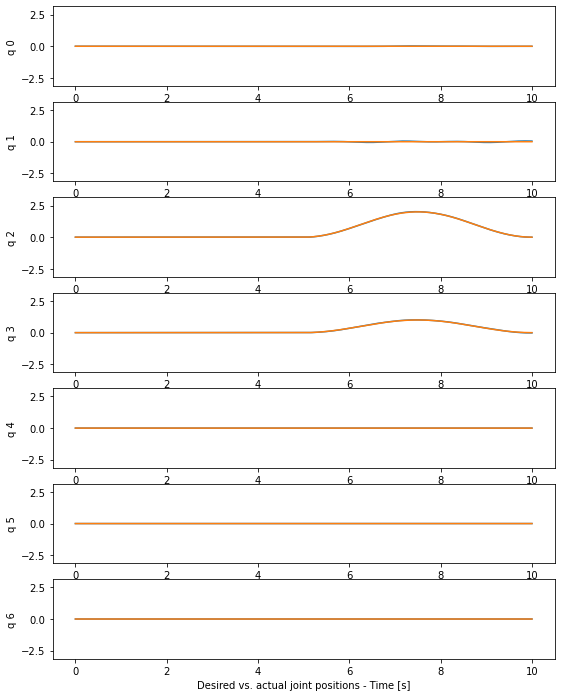

In [421]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

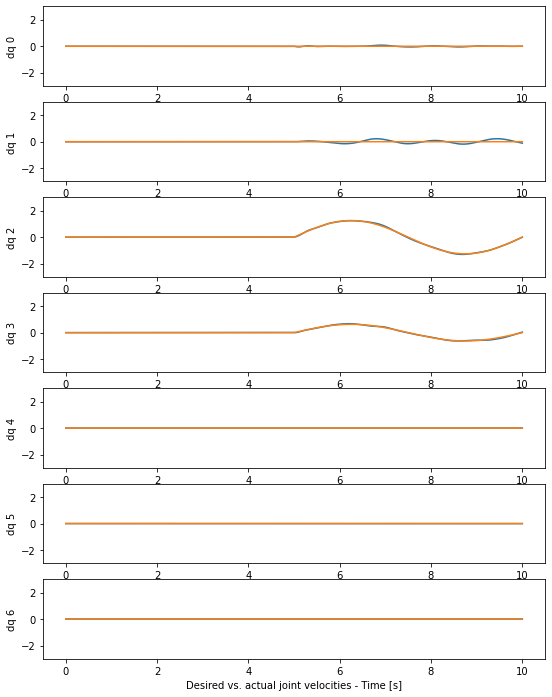

In [422]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

## Question 3: End-effector control
As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results

In [423]:
T = 10.

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.simulate_robot(robot_controller2, T=T)